#### [PyTorch를 활용한 머신러닝, 딥러닝 철저 입문]
## [Chapter 7-3] 예제: 옷 이미지 분류

---

## \#1. Import Modules

In [1]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import gzip

import numpy as np

import pandas as pd

from sklearn import datasets, model_selection

from matplotlib import pyplot as plt
from matplotlib import cm
%matplotlib inline

---

## \#2. Load Data

### 2-1. Get FASHION-MNIST `feature` Data

In [2]:
with gzip.open('./data/fashion_mnist/train-images-idx3-ubyte.gz', 'rb') as f:
    mnist_data = np.frombuffer(f.read(), np.uint8, offset=16)
    mnist_data = mnist_data.reshape(-1, 784)

#### mnist data 의 X (feature) 를 255로 정규화 해서 변수에 저장

In [3]:
mnist_data = mnist_data / 255
mnist_data.shape

(60000, 784)

### 2-2. get FASHION-MNIST `label` Data

In [4]:
with gzip.open('./data/fashion_mnist/train-labels-idx1-ubyte.gz', 'rb') as f:
    mnist_label = np.frombuffer(f.read(), np.uint8, offset=8)

mnist_label.shape

(60000,)

- label은 총 10가지이며, 다음과 같이 숫자로 label 되어있다.

In [26]:
mnist_label[:10]

array([9, 0, 0, 3, 0, 2, 7, 2, 5, 5], dtype=uint8)

#### 각 숫자가 의미하는 바는 다음과 같다.

```
Label    Description
-----    -----------
0	     T-shirt/top
1	     Trouser
2	     Pullover
3	     Dress
4	     Coat
5	     Sandal
6	     Shirt
7	     Sneaker
8	     Bag
9	     Ankle boot
```

---

## \#3. DataFrame

### 3-1. Create DataFrame in `df`

In [5]:
df = pd.DataFrame(mnist_data)
print(df.shape)
df.tail()

(60000, 784)


,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
59995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
59996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
59997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.019608,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
59998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.258824,0.211765,0.196078,0.019608,0.0,0.003922,0.0,0.0,0.0,0.0
59999,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0


총 60000개의 데이터이고, 각 데이터는 `784(=28*28)` 개의 feature로 이루어져있음을 알 수 있다.

---

## \#4. Show sample Images

이미지의 샘플을 한 번 확인해보자.

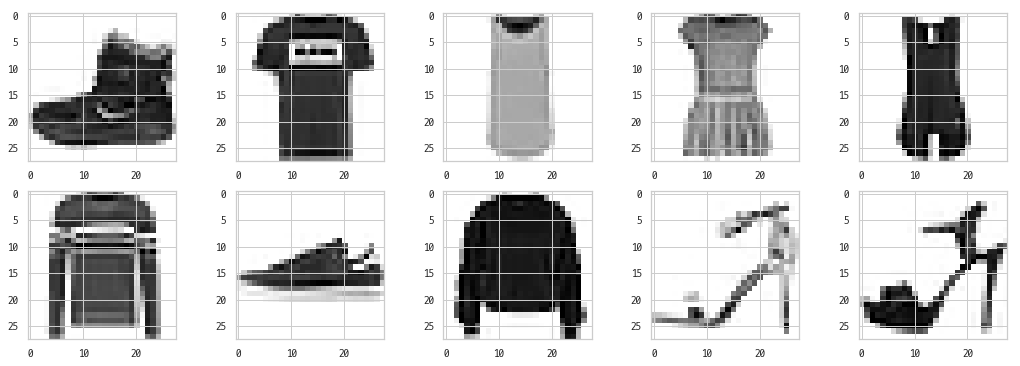

In [6]:
plt.figure(figsize=(18, 6))

for i in range(10):
    plt.subplot(2, 5,i+1)
    plt.imshow(mnist_data[i].reshape(28, 28), cmap=cm.gray_r)

plt.show()

`0 ~ 255`사이의 값 (여기서는 정규화됨)을 가지는 grey scale의 이미지임을 확인할 수 있다.

---

## \#3. Training / Test Data

### 3-1. Get Train / Test data by `train_test_split`

train data는 70000개의 데이터 중 5000개, test data는 500개를 추출하기로 한다.

In [7]:
train_size = 5000
test_size = 500

train_X, test_X, train_y, test_y = model_selection.train_test_split(mnist_data, mnist_label, \
                                                                    train_size = train_size, test_size=test_size)

print(train_X.shape, train_y.shape)
print(test_X.shape, test_y.shape)

(5000, 784) (5000,)
(500, 784) (500,)


### 3-2. 2D Array for CNN

In [8]:
# reshape: (Data nums, channel nums, height, width)
train_X = train_X.reshape(len(train_X), 1, 28, 28)
test_X = test_X.reshape(len(test_X), 1, 28, 28)

---

## \#4. Make Tensor

### 4-1. Transform Data Type

#### 완성된 train, test 데이터를 PyTorch의 `tensor 데이터`로 변환한다.

In [9]:
# train data
train_X = torch.from_numpy(train_X).float()
train_y = torch.from_numpy(train_y).long()

# test data
test_X = torch.from_numpy(test_X).float()
test_y = torch.from_numpy(test_y).long()

train_X.shape, train_y.shape

(torch.Size([5000, 1, 28, 28]), torch.Size([5000]))

#### train의 X와 y데이터를 `tensorDataset` 으로 합친다.

In [10]:
train = TensorDataset(train_X, train_y)
train[0][0].shape, train[0][1]

(torch.Size([1, 28, 28]), tensor(4))

- train의 각 element들은 feature와 label의 쌍으로 이루어져있음을 확인
- 첫 번째 쌍은 `28 x 28`의 2차원 텐서와, `2`라는 label의 쌍으로 이루어져 있다.

### 4-2. Mini Batch

#### train 데이터를 미니배치로 학습시킬 수 있도록 100개 단위로 분할한다.

In [11]:
train_loader = DataLoader(train, batch_size=100, shuffle=True)

---

## \#5. Neural Network Composition

### 5-1. Neural Network class

In [32]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        
        # 합성곱층
        self.conv1 = nn.Conv2d(1, 6, 5) #(입력 채널 수, 출력 채널 수, 필터크기)
        self.conv2 = nn.Conv2d(6, 16, 5)
        
        # 완전연결층
        # 입력노드수 : ((28-5+1) / 2) -5+1) / 2 = 4
        self.func1 = nn.Linear(4 * 4 * 16, 64)
        self.func2 = nn.Linear(64, 10)
        
        
    def forward(self, x):
        # 입력층 - 합성곱1층
        x = F.relu(self.conv1(x))
        # 풀링1층 : 풀링크기 2
        x = F.max_pool2d(x, 2)
        # 합성곱2층
        x = F.relu(self.conv2(x))
        # 풀링2층 : 풀링크기 2
        x = F.max_pool2d(x, 2)
        
        # len = 256의 1차원 텐서로 풀어주기
        x = x.view(-1, 256)
        
        # 완전연결층
        x = F.relu(self.func1(x))
        
        # 출력층
        x = self.func2(x)
        # 출력층 활성화함수 : log_softmax
        y = F.log_softmax(x, dim=1)
        
        return y

### 5-2. NN Instance 생성

In [13]:
model = Net()
model

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (func1): Linear(in_features=256, out_features=64, bias=True)
  (func2): Linear(in_features=64, out_features=10, bias=True)
)

합성곱이 두 층 있고, 완전연결층과 출력층까지 확인

---

## \#6. Model Training

### 6-1. Loss Function

In [14]:
criterion = nn.CrossEntropyLoss()

### 6-2. Optimizer

In [15]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

### 6-3. Training

In [16]:
%%time
print("{} \t {}".format("epoch", "total loss"))
print("----- \t ----------------------")

for epoch in range(1000):
    total_loss = 0
    
    for train_X, train_y in train_loader:
        
        # 계산 그래프 구성
        train_X, train_y = Variable(train_X), Variable(train_y)
        
        # gradient 초기화
        optimizer.zero_grad()
        
        # forward 계산
        output = model.forward(train_X)
        
        # loss 계산
        loss = criterion(output, train_y)
        
        # 오차 역전파
        loss.backward()
        
        # gradient update
        optimizer.step()
        
        # 누적 오차 계산
        total_loss += loss.data
        
    # 100번째 epoch마다 loss 출력    
    if (epoch+1) % 100 == 0:
        print("{} \t {}".format(epoch+1, total_loss))

epoch 	 total loss
----- 	 ----------------------
100 	 7.493796348571777
200 	 0.9473741054534912
300 	 0.10831628739833832
400 	 0.02276545763015747
500 	 0.01039691548794508
600 	 0.00788822304457426
700 	 0.0008879524539224803
800 	 0.0029146333690732718
900 	 0.0004393463605083525
1000 	 0.004260385874658823
CPU times: user 18min 38s, sys: 5min 43s, total: 24min 21s
Wall time: 16min 32s


- 16분이나 걸렸다..

---

## \#7. Accuracy

### 7-1. test data 로 accuracy 계산

In [19]:
# 계산 그래프 구성
test_X, test_y = Variable(test_X), Variable(test_y)

# 결과를 0 또는 1이 되도록 변환
result = torch.max(model(test_X).data, 1)[1]

# test_y 와 결과가 같은 예측값의 개수 (맞춘 개수) 계산
accuracy = sum(test_y.data.numpy() == result.numpy()) / len(test_y.data.numpy())

accuracy

0.836

- 약 83.6% 의 정확도를 보인다.

---

## \#8. Confirmation

#### 어떤 이미지들을 틀렸는지 확인해보자.

- test의 정답 label

In [23]:
test_y[:10]

tensor([0, 1, 2, 9, 0, 5, 9, 2, 3, 0])

- model이 예측한 label

In [24]:
result[:10]

tensor([0, 1, 2, 9, 0, 5, 7, 2, 6, 0])

6번째 이미지와, 9번째 이미지를 틀렸음을 알 수 있다.

- 6번째 이미지 : `정답 9` (ankle boot) / `예측 7` (sneaker)
- 9번째 이미지 : `정답 3` (Dress) / `예측 6` (Shirt)

#### 6, 9번째의 이미지 확인

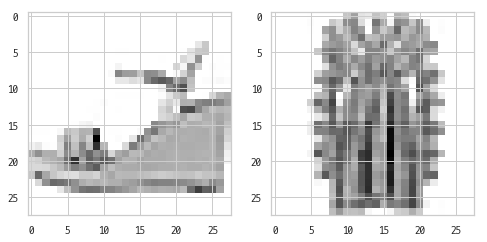

In [31]:
plt.figure(figsize=(8, 4))

plt.subplot(121)
plt.imshow(test_X[5].reshape(28, 28), cmap=cm.gray_r)

plt.subplot(122)
plt.imshow(test_X[8].reshape(28, 28), cmap=cm.gray_r)

plt.show()

- ankle boot를 sneaker로 잘못 예측하고,
- 오른쪽의 Dress는 Shirt로 잘못 예측


- 헷갈릴 수 있겠군..